# Model Reproducibility

In this notebook I will reproduce one of the examples from the publication associated to the model and make sure the Ersilia Model Hub implementation is giving the same results.
The test is explained in the ReadMe File

## Evaluation Metrics

The model performance will be assessed using different statistical measures. A receiver operating characteristic (ROC) curve, which plots the true-positive rate against the false positive rate, was used to estimate the predictive power of the classification model.



*   true-positive rate (tpr) measures the proportion of actual positive cases that are correctly identified by a classification model.
*   false positive rate (fpr) measures the proportion of actual negative cases that are incorrectly identified as positive.


The area under the ROC curve (i.e., AUC-ROC) is a numerical value between 0 and 1. The higher the value, the better the predictive power.

Sensitivity indicates the proportion of true positives correctly predicted as positive.

Specificity is the ability of the model to correctly predict true negatives as negative.

Balanced accuracy (BACC) is an average of the sensitivity and specificity.

Cohen’s kappa is another metric used in this study that measures agreement between the actual classes and the classes predicted by the classifier.

where TP: true positives;

FN: false negatives;

TN: true negatives;

 FP: false positives.

In [1]:
# In this codeblock I will import the necessary packages and specify the paths to relevant folders

## Mount google drive
from google.colab import drive
drive.mount("/content/drive")

import sys
import os
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score, balanced_accuracy_score, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns


_ = sys.path.append("/usr/local/lib/python3.7/site-packages")


sys.path.append("/content/drive/MyDrive/Ersilia_ModelValidation")


# specify your output folder

predictions_folder = "/content/drive/MyDrive/Ersilia_ModelValidation/Data/Output/eos74bo_validation"  # @param {type:"string"}

# specify the input folder path

plot_folder = "/content/drive/MyDrive/Ersilia_ModelValidation/Plots/Model_reproducibility_plot"  # @param {type:"string"}

Mounted at /content/drive


# Expolatory Data Analysis of the test data

In [16]:
# read the test data that was used for validation
test_data= pd.read_csv(r"/content/drive/MyDrive/Ersilia_ModelValidation/Data/Input/eos74bo_validation/valid_test_data.csv")
test_data.head()

,standardized_smiles,inchi_key,outcomes
0,CCOC(=O)N[C@@H]1CC[C@@H]2[C@@H](C1)C[C@H]1C(=O...,ZBGXUVOIWDMMJE-JNGLTUCJSA-N,1
1,Clc1cc(Cl)c(OCC#CI)cc1Cl,CTETYYAZBPJBHE-UHFFFAOYSA-N,1
2,c1ccc(-c2ccc(C(c3ccccc3)n3ccnc3)cc2)cc1,OCAPBUJLXMYKEJ-UHFFFAOYSA-N,1
3,Cc1cc(/C=C/C#N)cc(C)c1Nc1ccnc(Nc2ccc(C#N)cc2)n1,YIBOMRUWOWDFLG-ONEGZZNKSA-N,1
4,CN(C/C=C/C#CC(C)(C)C)Cc1cccc2ccccc12,DOMXUEMWDBAQBQ-WEVVVXLNSA-N,1


In [17]:
# Map classes to solubility outcomes
test_data['Solubility'] = test_data['outcomes'].map({1: 'low_solubility', 0: 'high_solubility'})

### Data distribution: How many molecules do I have in each dataset? How many low solubles and how many high solubles molecules

In [18]:
#Count the number of molecules in each class
class_count= test_data['Solubility'].value_counts()
print(class_count)

high_solubility    139
low_solubility      37
Name: Solubility, dtype: int64


<ipython-input-21-c41552c6109e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_count.index, y=class_count, palette='tab10')


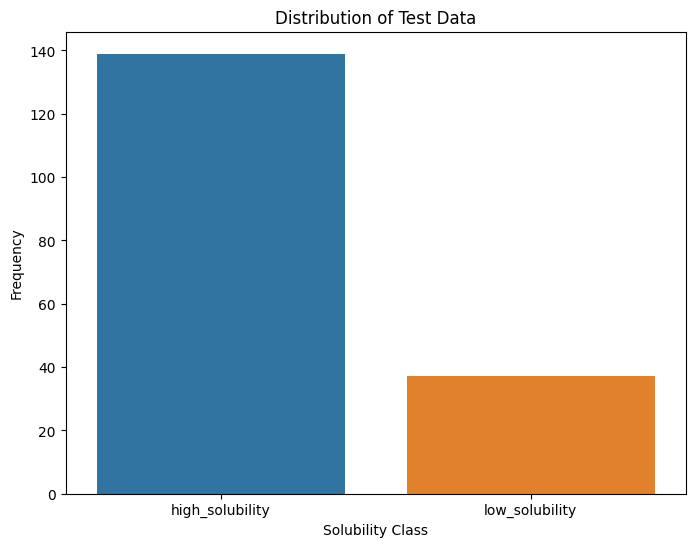

In [21]:
#Plot a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=class_count.index, y=class_count, palette='tab10')
plt.title('Distribution of Test Data')
plt.xlabel('Solubility Class')
plt.ylabel('Frequency')
plt.show()

It is observed that there is data imbalance in the test data. This can be handled using resampling or algorithm but this will be ignored for this task as evaluation metric such as  ROC curve for better interpretation of result

### Check data Quality

To ensure the quality of the validation, I will check to see the validation data is not present in the   [subset of train data](https://pubchem.ncbi.nlm.nih.gov/bioassay/1645848) that was made publicly available.

In [22]:
train_data = pd.read_csv(r"/content/drive/MyDrive/Ersilia_ModelValidation/Data/Input/eos74bo_validation/train_data.csv")
train_data.shape

(2455, 3)

In [23]:
# Extract the unique Inchi_keys from train_data and test_data
train_inchi_keys = set(train_data['inchi_key'])
test_inchi_keys = set(test_data['inchi_key'])

# Check for common Inchi_keys
common_inchi_keys = train_inchi_keys.intersection(test_inchi_keys)

if len(common_inchi_keys) == 0:
    print("No common Inchi_keys found between train_data and test_data.")
else:
    print("There are common Inchi_keys between train_data and test_data.")
    print("Common Inchi_keys:", common_inchi_keys)

No common Inchi_keys found between train_data and test_data.


There is no molecules in train data that is also present in test data

# Model Evaluations

In [5]:
# In this codeblock I will load the predictions obtained from the original author's code implementation from the /data folder


adme_ncats_result = pd.read_csv(os.path.join(predictions_folder, 'adme@ncats_npc_predictions.csv'))
adme_ncats_result.head()

,standardized_smiles,inchi_key,outcomes,predicted_probability,predicted_outcomes,Prediction
0,CCOC(=O)N[C@@H]1CC[C@@H]2[C@@H](C1)C[C@H]1C(=O...,ZBGXUVOIWDMMJE-JNGLTUCJSA-N,1,1.0,1,low solubility
1,Clc1cc(Cl)c(OCC#CI)cc1Cl,CTETYYAZBPJBHE-UHFFFAOYSA-N,1,1.0,1,low solubility
2,c1ccc(-c2ccc(C(c3ccccc3)n3ccnc3)cc2)cc1,OCAPBUJLXMYKEJ-UHFFFAOYSA-N,1,1.0,1,low solubility
3,Cc1cc(/C=C/C#N)cc(C)c1Nc1ccnc(Nc2ccc(C#N)cc2)n1,YIBOMRUWOWDFLG-ONEGZZNKSA-N,1,1.0,1,low solubility
4,CN(C/C=C/C#CC(C)(C)C)Cc1cccc2ccccc12,DOMXUEMWDBAQBQ-WEVVVXLNSA-N,1,1.0,1,low solubility


## Author's model evaluation

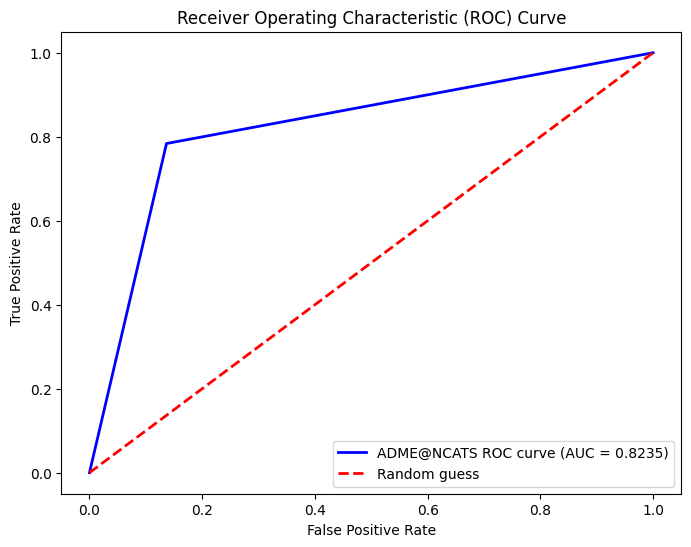

In [8]:
# In this codeblock I will recreate the figure or value I am to reproduce, for example an AUROC

fpr, tpr, thresholds = roc_curve(adme_ncats_result['outcomes'], adme_ncats_result['predicted_outcomes'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ADME@NCATS ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
# Save the plot
plt.savefig(os.path.join(plot_folder, 'ADME@NCATS_AUROC.png'))
plt.show()

Other evaluation metrics

In [10]:
auc_roc= roc_auc_score(adme_ncats_result['outcomes'], adme_ncats_result['predicted_outcomes'])
bacc = balanced_accuracy_score(adme_ncats_result['outcomes'], adme_ncats_result['predicted_outcomes'])
tn, fp, fn, tp = confusion_matrix(adme_ncats_result['outcomes'], adme_ncats_result['predicted_outcomes']).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
kappa = cohen_kappa_score(adme_ncats_result['outcomes'], adme_ncats_result['predicted_outcomes'])

# Create a DataFrame to store the metric results
metric_results_adme_ncats = pd.DataFrame({
    'Metric': ['AUC-ROC', 'BACC', 'sensitivity', 'specificity',  'Kappa'],
    'Score': [auc_roc, bacc, sensitivity ,specificity, kappa]
})

print(metric_results_adme_ncats.T)

               0         1            2            3        4
Metric   AUC-ROC      BACC  sensitivity  specificity    Kappa
Score   0.823547  0.823547     0.783784     0.863309  0.58345


## Ersilia eos74bo model evaluation

In [11]:
# In this codeblock I will load the predictions obtained from the Ersilia Model Hub implementation saved in the /data folder
eos74bo_validation_prediction = pd.read_csv(os.path.join(predictions_folder, 'eos74bo_npc_predictions.csv'))
eos74bo_validation_prediction.head()

,standardized_smiles,inchi_key,outcomes,predicted_probability,predicted_outcomes,Prediction
0,CCOC(=O)N[C@@H]1CC[C@@H]2[C@@H](C1)C[C@H]1C(=O...,ZBGXUVOIWDMMJE-JNGLTUCJSA-N,1,0.997,1,low solubility
1,Clc1cc(Cl)c(OCC#CI)cc1Cl,CTETYYAZBPJBHE-UHFFFAOYSA-N,1,1.000,1,low solubility
2,c1ccc(-c2ccc(C(c3ccccc3)n3ccnc3)cc2)cc1,OCAPBUJLXMYKEJ-UHFFFAOYSA-N,1,0.996,1,low solubility
3,Cc1cc(/C=C/C#N)cc(C)c1Nc1ccnc(Nc2ccc(C#N)cc2)n1,YIBOMRUWOWDFLG-ONEGZZNKSA-N,1,1.000,1,low solubility
4,CN(C/C=C/C#CC(C)(C)C)Cc1cccc2ccccc12,DOMXUEMWDBAQBQ-WEVVVXLNSA-N,1,0.996,1,low solubility


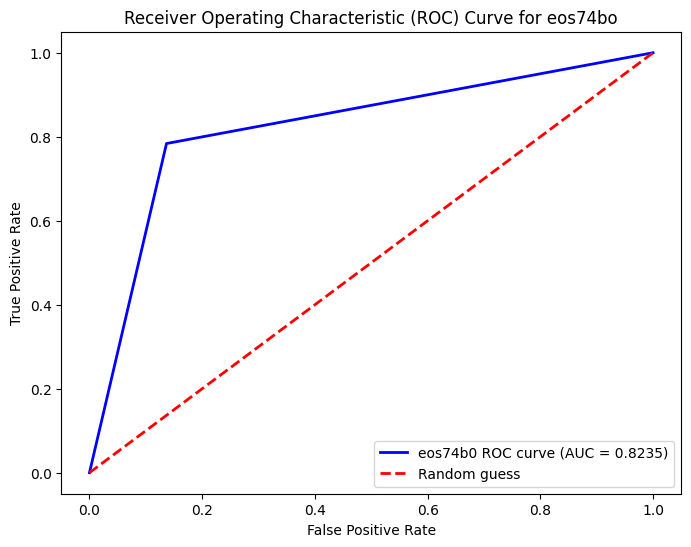

In [12]:
# In this codeblock I will recreate the figure or value I am to reproduce, for example an AUROC

fpr, tpr, thresholds = roc_curve(eos74bo_validation_prediction['outcomes'], eos74bo_validation_prediction['predicted_outcomes'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='eos74b0 ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for eos74bo')
plt.legend(loc='lower right')
# Save the plot
plt.savefig(os.path.join(plot_folder, 'eos74bo_AUROC.png'))
#/content/drive/MyDrive/Ersilia_ModelValidation/Plots/Model_reprocibility_plot
plt.show()

In [13]:
 auc_roc = roc_auc_score(eos74bo_validation_prediction['outcomes'], eos74bo_validation_prediction['predicted_outcomes'])
bacc = balanced_accuracy_score(eos74bo_validation_prediction['outcomes'], eos74bo_validation_prediction['predicted_outcomes'])
tn, fp, fn, tp = confusion_matrix(eos74bo_validation_prediction['outcomes'], eos74bo_validation_prediction['predicted_outcomes']).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
kappa = cohen_kappa_score(eos74bo_validation_prediction['outcomes'], eos74bo_validation_prediction['predicted_outcomes'])

# Create a DataFrame to store the metric results
metric_results_eos74bo = pd.DataFrame({
    'Metric': ['AUC-ROC', 'BACC', 'sensitivity', 'specificity',  'Kappa'],
    'Score': [auc_roc, bacc, sensitivity ,specificity, kappa]
})

print(metric_results_eos74bo.T)

               0         1            2            3        4
Metric   AUC-ROC      BACC  sensitivity  specificity    Kappa
Score   0.823547  0.823547     0.783784     0.863309  0.58345


In [14]:
# In this codeblock I will compare the orginal implementation vs the EMH result

# Add model names to each DataFrame
metric_results_adme_ncats['Model'] = 'ADME@NCATS'
metric_results_eos74bo['Model'] = 'eos74bo'

# Concatenate the two DataFrames horizontally
comparison_table = pd.concat([metric_results_adme_ncats, metric_results_eos74bo], axis=0)

# Round the values to 2 decimal places
comparison_table_rounded = comparison_table.round(2)

# Transpose the comparison table
comparison_table_transposed = comparison_table_rounded.T

# Print the transposed comparison table
print(comparison_table_transposed)

                 0           1            2            3           4        0  \
Metric     AUC-ROC        BACC  sensitivity  specificity       Kappa  AUC-ROC   
Score         0.82        0.82         0.78         0.86        0.58     0.82   
Model   ADME@NCATS  ADME@NCATS   ADME@NCATS   ADME@NCATS  ADME@NCATS  eos74bo   

              1            2            3        4  
Metric     BACC  sensitivity  specificity    Kappa  
Score      0.82         0.78         0.86     0.58  
Model   eos74bo      eos74bo      eos74bo  eos74bo  


## I was able to achieve the same result with the two models when validated with a subset of NPC marketed drugs with 176 dataset